In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, roc_curve)
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [21]:
# Load dataset
df_main = pd.read_csv('/kaggle/input/issfraud/cleaned_data.csv', low_memory=False, index_col=0)

# Make a copy to avoid modifying the original
df = df_main.copy()

# Separate target variable
y_all = df['isFraud'].values
df.drop(columns=['isFraud'], inplace=True)

In [22]:
# Replace infrequent 'card2' values with 'others'
card2_counts = df['card2'].value_counts(dropna=False)
common_values = card2_counts[card2_counts > 1000].index
df['card2'] = df['card2'].apply(lambda x: x if x in common_values else 'others')

# Drop high-cardinality or non-useful columns
df.drop(columns=['card5', 'card1'], inplace=True)

In [23]:
# Define feature column groups
label_col = ['addr2']
cat_col = ['card2', 'P_emaildomain', 'ProductCD', 'card3', 'card4', 'addr1', 'DeviceType']
num_col = [
    'dist1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
    'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'VerificationSet', 'MatchingCount'
]

# Convert categorical columns to string before encoding
df[cat_col] = df[cat_col].astype(str)

In [24]:
# Initialize transformers
label_encoder = OrdinalEncoder()
onehot_encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

# Create column transformer
ct = ColumnTransformer(transformers=[
    ('label', label_encoder, label_col),
    ('onehot', onehot_encoder, cat_col),
    ('num', scaler, num_col)
])

In [25]:
# Keep already-encoded columns if needed (optional; you can remove if unnecessary)
keep_cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
keep = df[keep_cols]

In [26]:
# Apply transformations
X_transformed = ct.fit_transform(df)

# Get column names
X_transformed_df = pd.DataFrame(X_transformed, columns=ct.get_feature_names_out())

# Combine with optional kept features
X_all = pd.concat([X_transformed_df, keep], axis=1)

In [27]:
# Use only normal samples for training/validation
X_train = X_all[y_all == 0]
X_test = X_all  # Evaluate on full data

# Split validation from normal training data
X_train, X_val = train_test_split(X_train, test_size=0.1, random_state=42)

In [28]:
input_dim = X_train.shape[1]

def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder

In [29]:
autoencoder = build_autoencoder(input_dim)

history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_val, X_val),
    shuffle=True,
    verbose=1
)

Epoch 1/50
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.1963 - val_loss: 0.0560
Epoch 2/50
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0394 - val_loss: 0.0207
Epoch 3/50
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0241 - val_loss: 0.0195
Epoch 4/50
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0242 - val_loss: 0.0470
Epoch 5/50
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0248 - val_loss: 0.0156
Epoch 6/50
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0243 - val_loss: 0.0137
Epoch 7/50
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0156 - val_loss: 0.0149
Epoch 8/50
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0366 - val_loss: 0.0129
Epoch 9/50
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0169 - val_loss: 0.0111
Epoch 10/50
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0167 - val_loss: 0.0138
Epoch 11/50
1994/1994 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0253 - val_loss: 0.0158
Epoch 12/50
1994/1994 ━

In [30]:
# Reconstruction errors
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.square(reconstructions - X_test), axis=1)

# Threshold: 95th percentile of train errors
threshold = np.percentile(np.mean(np.square(autoencoder.predict(X_train) - X_train), axis=1), 95)

# Prediction
autoencoder_preds = (mse > threshold).astype(int)


18358/18358 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step
15949/15949 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step


In [31]:
def evaluate_model(name, y_true, y_pred, scores=None, plot_roc=True):
    print(f"\n=== Evaluation for {name} ===")
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # If scores are provided, compute ROC AUC and PR AUC
    if scores is not None:
        roc_auc = roc_auc_score(y_true, scores)
        pr_auc = average_precision_score(y_true, scores)
    else:
        roc_auc = roc_auc_score(y_true, y_pred)
        pr_auc = average_precision_score(y_true, y_pred)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    print(f"PR AUC:    {pr_auc:.4f}")
    
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    if plot_roc and scores is not None:
        fpr, tpr, _ = roc_curve(y_true, scores)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



=== Evaluation for Autoencoder ===
Accuracy:  0.9253
Precision: 0.1462
Recall:    0.2380
F1 Score:  0.1812
ROC AUC:   0.6563
PR AUC:    0.1079

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96    567057
           1       0.15      0.24      0.18     20384

    accuracy                           0.93    587441
   macro avg       0.56      0.59      0.57    587441
weighted avg       0.94      0.93      0.93    587441

Confusion Matrix:
 [[538725  28332]
 [ 15532   4852]]


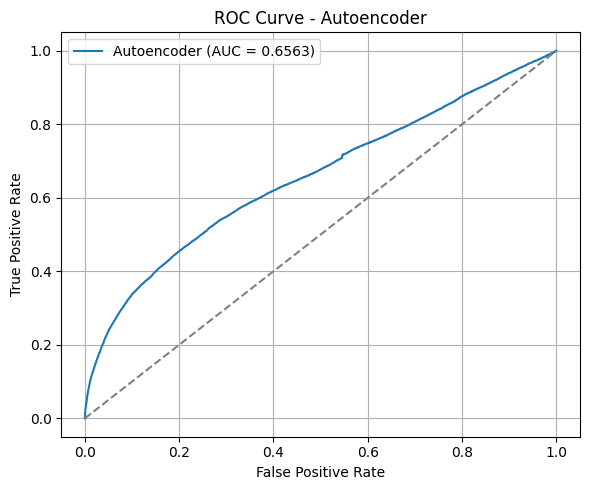

In [32]:
evaluate_model("Autoencoder", y_all, autoencoder_preds, scores=mse)

In [33]:
def build_deep_svdd(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(input_layer)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dense(32, activation='relu', name='feature_layer')(x)  # Feature space
    model = Model(inputs=input_layer, outputs=x)
    return model

In [34]:
deep_svdd = build_deep_svdd(input_dim)
optimizer = tf.keras.optimizers.Adam()

# Get center of the hypersphere
center = np.mean(deep_svdd.predict(X_train), axis=0)

# Custom training loop
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        output = deep_svdd(x)
        loss = tf.reduce_mean(tf.square(output - center))
    grads = tape.gradient(loss, deep_svdd.trainable_variables)
    optimizer.apply_gradients(zip(grads, deep_svdd.trainable_variables))
    return loss

# Training
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
for epoch in range(50):
    loss = train_step(X_train_tensor)
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.4f}")


15949/15949 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
Epoch 0, Loss: 0.1641
Epoch 5, Loss: 0.0523
Epoch 10, Loss: 0.0327
Epoch 15, Loss: 0.0258
Epoch 20, Loss: 0.0219
Epoch 25, Loss: 0.0191
Epoch 30, Loss: 0.0167
Epoch 35, Loss: 0.0148
Epoch 40, Loss: 0.0132
Epoch 45, Loss: 0.0116


In [35]:
# Compute distances to center
X_test_encoded = deep_svdd.predict(X_test)
distances = np.linalg.norm(X_test_encoded - center, axis=1)

# Threshold
threshold_svdd = np.percentile(np.linalg.norm(deep_svdd.predict(X_train) - center, axis=1), 95)

# Prediction
svdd_preds = (distances > threshold_svdd).astype(int)


18358/18358 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
15949/15949 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step



=== Evaluation for Deep SVDD ===
Accuracy:  0.9257
Precision: 0.1512
Recall:    0.2472
F1 Score:  0.1876
ROC AUC:   0.6769
PR AUC:    0.1082

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96    567057
           1       0.15      0.25      0.19     20384

    accuracy                           0.93    587441
   macro avg       0.56      0.60      0.57    587441
weighted avg       0.94      0.93      0.93    587441

Confusion Matrix:
 [[538767  28290]
 [ 15346   5038]]


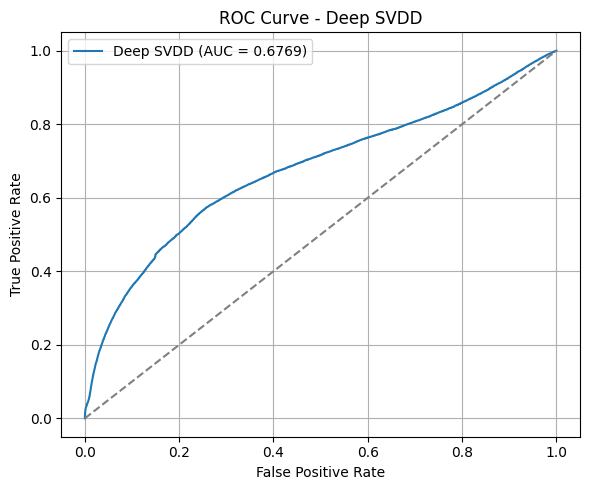

In [36]:
evaluate_model("Deep SVDD", y_all, svdd_preds, scores=distances)
